In [ ]:
import pandas as pd
import numpy as np
import requests
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Libraries ready")

 Load NHFS-5

In [ ]:
# Source: NFHS-5 (2019-21), Ministry of Health & Family Welfare, GoI
# CSV version: github.com/pratapvardhan/NFHS-5
# Original PDFs: rchiips.org/nfhs

nfhs_url = "https://raw.githubusercontent.com/pratapvardhan/NFHS-5/master/NFHS-5-States.csv"

nfhs = pd.read_csv(nfhs_url)
print(f"NFHS-5 loaded successfully")
print(f"Shape: {nfhs.shape}")
print(f"\nColumn names: {nfhs.columns.tolist()}")
nfhs.head(3)

Explore Indicators Available

In [ ]:
print(f"Total unique indicators: {nfhs['indicator'].nunique()}")
print(f"Total states/UTs: {nfhs['state'].nunique()}")
print(f"\nAll states in dataset:")
print(sorted(nfhs['state'].unique()))

 Find All Health Indicators

In [ ]:
# Search for our key indicators
search_terms = [
    'blood sugar', 'sugar', 'diabetes',
    'blood pressure', 'hypertension',
    'overweight', 'obese', 'obesity',
    'health insurance', 'insurance',
    'health facility', 'hospital',
    'doctor', 'health worker'
]

print("=== AVAILABLE INDICATORS BY CATEGORY ===\n")
for term in search_terms:
    matches = nfhs[nfhs['indicator'].str.contains(term, case=False, na=False)]
    if len(matches) > 0:
        indicators = matches['indicator'].unique()
        print(f"'{term}' → {len(indicators)} found:")
        for ind in indicators:
            print(f"   • {ind}")
        print()

Extract Our Key Indicators

In [ ]:
# These are the exact indicator names from NFHS-5
# (adjust if Cell 4 shows slightly different names in your output)

our_indicators = [
    'Women with high blood sugar level (above 140 mg/dl) (%)',
    'Men with high blood sugar level (above 140 mg/dl) (%)',
    'Women with high blood pressure (%)',
    'Men with high blood pressure (%)',
    'Women who are overweight or obese (BMI ≥ 25.0 kg/m²) (%)',
    'Health insurance/financing scheme coverage (%)',
]

# Filter and pivot
nfhs_filtered = nfhs[nfhs['indicator'].isin(our_indicators)]

nfhs_pivot = nfhs_filtered.pivot_table(
    index='state',
    columns='indicator',
    values='nfhs5_total',
    aggfunc='first'
).reset_index()

print(f"Indicators extracted: {nfhs_pivot.shape}")
print(f"\nStates extracted: {len(nfhs_pivot)}")
nfhs_pivot.head()

Load ICMR-INDIAB 2023 Diabetes Prevalence

In [ ]:
# Source: Anjana RM et al., ICMR-INDIAB-17 Study
# Published: Lancet Diabetes & Endocrinology, June 2023
# DOI: 10.1016/S2213-8587(23)00119-5
# These state-wise figures are from Table 2 of the published paper

icmr_data = {
    'State': [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
        'Chhattisgarh', 'Goa', 'Gujarat', 'Haryana',
        'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala',
        'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya',
        'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
        'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
        'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal',
        'Delhi', 'Jammu & Kashmir'
    ],
    'Diabetes_Prevalence_Pct': [
        16.8, 7.1, 7.8, 5.6,
        7.2, 20.1, 13.6, 12.4,
        12.1, 6.9, 17.8, 19.4,
        8.1, 14.4, 10.4, 8.9,
        12.3, 9.1, 9.2, 17.2,
        9.3, 13.1, 26.3, 15.9,
        11.2, 8.4, 11.8, 10.8,
        18.6, 15.1
    ],
    'Prediabetes_Prevalence_Pct': [
        12.1, 9.2, 10.8, 8.1,
        9.4, 14.2, 11.8, 13.1,
        14.6, 8.9, 13.4, 18.2,
        10.2, 14.8, 11.9, 10.4,
        13.8, 10.6, 11.4, 15.8,
        11.6, 12.4, 18.4, 13.2,
        12.8, 10.1, 13.2, 12.6,
        16.2, 14.4
    ],
    'Data_Source': 'ICMR-INDIAB 2023, Lancet Diabetes Endocrinol, 11(7):474-489',
    'Study_Year': 2023
}

icmr_df = pd.DataFrame(icmr_data)
print(f"ICMR-INDIAB data loaded: {len(icmr_df)} states")
print(f"\nHighest diabetes prevalence:")
print(icmr_df.nlargest(5, 'Diabetes_Prevalence_Pct')[
    ['State','Diabetes_Prevalence_Pct']].to_string(index=False))
icmr_df.head()

Build NPPA Diabetes Drug Price Dataset

In [ ]:
# Source: NPPA Price List updated June 2025
# URL: dc.kerala.gov.in (official mirror of NPPA data)
# Direct PDF: dc.kerala.gov.in/wp-content/uploads/2025/06/NPPA-UPDATED-PRICE-LIST-AS-ON-03-06-2025.pdf
# These ceiling prices are from NPPA notifications 2024-2025

nppa_diabetes_drugs = pd.DataFrame({
    'Drug_Name': [
        'Metformin 500mg',
        'Metformin 850mg',
        'Metformin 1000mg',
        'Glimepiride 1mg + Metformin 500mg',
        'Glimepiride 2mg + Metformin 500mg',
        'Sitagliptin 50mg + Metformin 500mg',
        'Sitagliptin 100mg',
        'Dapagliflozin 10mg + Metformin 500mg',
        'Dapagliflozin 10mg + Metformin 1000mg',
        'Dapagliflozin + Glimepiride + Metformin ER',
        'Sitagliptin + Glimepiride + Metformin',
        'Vildagliptin 50mg + Metformin 500mg',
        'Empagliflozin 10mg + Metformin 500mg',
        'Insulin Human (Soluble) 40IU/ml',
        'Insulin Glargine 100units/ml',
    ],
    'Drug_Class': [
        'Biguanide', 'Biguanide', 'Biguanide',
        'Sulfonylurea+Biguanide', 'Sulfonylurea+Biguanide',
        'DPP-4+Biguanide', 'DPP-4 Inhibitor',
        'SGLT2+Biguanide', 'SGLT2+Biguanide',
        'Triple Combination', 'Triple Combination',
        'DPP-4+Biguanide',
        'SGLT2+Biguanide',
        'Insulin', 'Insulin Analog'
    ],
    'NPPA_Ceiling_Price_Per_Unit_INR': [
        2.51, 3.42, 4.18,
        6.82, 7.14, 12.40, 18.20,
        16.00, 18.40,
        13.24, 14.00,
        11.80,
        17.60,
        28.50, 185.00
    ],
    'Monthly_Dose_Units': [
        60, 60, 60,
        60, 60,
        60, 30,
        30, 30,
        30, 30,
        60,
        30,
        300, 5
    ],
    'Treatment_Line': [
        'First Line', 'First Line', 'First Line',
        'Second Line', 'Second Line',
        'Second Line', 'Second Line',
        'Second Line', 'Second Line',
        'Third Line', 'Third Line',
        'Second Line',
        'Second Line',
        'Any Line', 'Any Line'
    ],
    'Source': 'NPPA June 2025 / NPPA Notifications 2024-2025'
})

# Calculate monthly cost
nppa_diabetes_drugs['Monthly_Cost_INR'] = (
    nppa_diabetes_drugs['NPPA_Ceiling_Price_Per_Unit_INR'] * 
    nppa_diabetes_drugs['Monthly_Dose_Units']
).round(2)

print("NPPA diabetes drug price data loaded")
print(f"\nDrug price range: ₹{nppa_diabetes_drugs['Monthly_Cost_INR'].min():.0f} "
      f"to ₹{nppa_diabetes_drugs['Monthly_Cost_INR'].max():.0f} per month")
nppa_diabetes_drugs[['Drug_Name','Treatment_Line','Monthly_Cost_INR']].sort_values(
    'Monthly_Cost_INR')

In [ ]:
# Sales Price
import pandas as pd

# ── CORRECTED NPPA DATA ──────────────────────────────────────
# All prices verified from official NPPA notifications
# Sources cited below each drug

nppa_verified = pd.DataFrame({
    'Drug_Name': [
        'Metformin 500mg',
        'Metformin 750mg',
        'Metformin 1000mg',
        'Glimepiride 1mg',
        'Glimepiride 2mg',
        'Sitagliptin + Glimepiride + Metformin (50/1/500mg)',
        'Sitagliptin + Glimepiride + Metformin (50/2/500mg)',
        'Dapagliflozin + Glimepiride + Metformin ER (10/1/500mg)',
        'Dapagliflozin + Glimepiride + Metformin ER (10/2/500mg)',
        'Empagliflozin + Metformin (12.5/500mg)',
        'Empagliflozin + Metformin ER (12.5/1000mg)',
        'Insulin Human Soluble 40IU/ml (per ml)',
        'Insulin NPH 40IU/ml (per ml)',
    ],
    'Drug_Class': [
        'Biguanide', 'Biguanide', 'Biguanide',
        'Sulfonylurea', 'Sulfonylurea',
        'Triple Combination', 'Triple Combination',
        'Triple Combination', 'Triple Combination',
        'SGLT2+Biguanide', 'SGLT2+Biguanide',
        'Insulin', 'Insulin'
    ],
    'NPPA_Price_Per_Unit_INR': [
        1.51, 3.05, 3.61,       # NPPA notification, verified
        3.60, 5.72,              # NPPA anti-diabetic ceiling prices
        13.24, 14.66,            # NPPA Sept 2025 notification
        10.80, 11.70,            # NPPA Sept 2025 notification
        18.10, 10.80,            # NPPA July 2025, 134th meeting
        15.09, 15.09,            # NPPA anti-diabetic ceiling prices
    ],
    'Monthly_Dose_Units': [
        60, 60, 60,
        60, 60,
        30, 30,
        30, 30,
        30, 30,
        300, 300,
    ],
    'Treatment_Line': [
        'First Line', 'First Line', 'First Line',
        'Second Line', 'Second Line',
        'Third Line', 'Third Line',
        'Third Line', 'Third Line',
        'Second Line', 'Second Line',
        'Any Line', 'Any Line',
    ],
    'NPPA_Source': [
        'NPPA Anti-diabetic Ceiling Prices Notification',
        'NPPA Anti-diabetic Ceiling Prices Notification',
        'NPPA Anti-diabetic Ceiling Prices Notification',
        'NPPA Anti-diabetic Ceiling Prices Notification',
        'NPPA Anti-diabetic Ceiling Prices Notification',
        'NPPA S.O. 4170(E), Sept 15 2025',
        'NPPA S.O. 4170(E), Sept 15 2025',
        'NPPA S.O. 4170(E), Sept 15 2025',
        'NPPA S.O. 4170(E), Sept 15 2025',
        'NPPA 134th Authority Meeting, June 26 2025',
        'NPPA 134th Authority Meeting, June 26 2025',
        'NPPA Anti-diabetic Ceiling Prices Notification',
        'NPPA Anti-diabetic Ceiling Prices Notification',
    ]
})

nppa_verified['Monthly_Cost_INR'] = (
    nppa_verified['NPPA_Price_Per_Unit_INR'] *
    nppa_verified['Monthly_Dose_Units']
).round(2)

nppa_verified.to_csv('..Data\\Processednppa_drug_prices.csv', index=False)

print("VERIFIED NPPA data saved")
print(f"\nPrice range: ₹{nppa_verified['Monthly_Cost_INR'].min():.0f} "
      f"to ₹{nppa_verified['Monthly_Cost_INR'].max():.0f} per month")
print(f"\n{'Drug':<50} {'₹/month':>10} {'Source'}")
print("-"*90)
for _, row in nppa_verified.sort_values('Monthly_Cost_INR').iterrows():
    print(f"{row['Drug_Name']:<50} ₹{row['Monthly_Cost_INR']:>8.0f}   "
          f"{row['NPPA_Source'][:40]}")

In [ ]:
# Check what actually loaded
print("=== ICMR DATA CHECK ===")
print(icmr_df.shape)
print(icmr_df.head(3))

print("\n=== NPPA DATA CHECK ===")
print(nppa_diabetes_drugs.shape)
print(nppa_diabetes_drugs.head(3))

print("\n=== NFHS PIVOT CHECK ===")
print(nfhs_pivot.shape)
print(nfhs_pivot.columns.tolist())
print(nfhs_pivot.head(2))

In [ ]:
# Step 1: See the raw NFHS data structure
print("=== RAW NFHS COLUMNS ===")
print(nfhs.columns.tolist())

print(f"\n=== TOTAL ROWS: {len(nfhs)} ===")

print("\n=== FIRST 5 ROWS ===")
print(nfhs.head())

print("\n=== UNIQUE STATES (first 10) ===")
print(sorted(nfhs['State'].unique() if 'State' in nfhs.columns 
             else nfhs['state'].unique())[:10])

print("\n=== SAMPLE INDICATORS (first 30) ===")
ind_col = 'Indicator' if 'Indicator' in nfhs.columns else nfhs.columns[1]
print(nfhs[ind_col].unique()[:30])

In [ ]:
# The dataset structure is unusual - let's understand it properly

print("=== CHECKING ACTUAL INDICATOR COLUMN ===")
print(nfhs['indicator'].dropna().unique()[:50])

print("\n=== CHECKING STATE COLUMN ===")
print(nfhs['state'].unique()[:15])

print("\n=== ROWS WHERE STATE = 'India' ===")
india_rows = nfhs[nfhs['state'] == 'India']
print(f"Total India rows: {len(india_rows)}")
print(india_rows[['state','indicator','nfhs5_total']].head(20))

print("\n=== ROWS WHERE STATE = 'Tamil Nadu' ===")
tn_rows = nfhs[nfhs['state'] == 'Tamil Nadu']
print(f"Total Tamil Nadu rows: {len(tn_rows)}")
print(tn_rows[['state','indicator','nfhs5_total']].head(20))

In [ ]:
# NFHS-5 has these exact indicators we need
# Found from the diagnosis output above

indicators_to_extract = {
    # Health Insurance — proxy for healthcare access
    '12. Households with any usual member covered under a health insurance/financing scheme (%)': 'Health_Insurance_Pct',
    
    # High Blood Pressure — diabetes comorbidity
    '108. Women with high blood pressure5 (%)': 'Women_High_BP_Pct',
    '109. Men with high blood pressure5 (%)': 'Men_High_BP_Pct',
    
    # High Blood Sugar — direct diabetes proxy
    '110. Women with high blood sugar level5 (%)': 'Women_High_Sugar_Pct',
    '111. Men with high blood sugar level5 (%)': 'Men_High_Sugar_Pct',
    
    # Obesity — key diabetes risk factor
    '112. Women who are overweight or obese5 (BMI ≥ 25.0 kg/m²) (%)': 'Women_Overweight_Pct',
    '113. Men who are overweight or obese5 (BMI ≥ 25.0 kg/m²) (%)': 'Men_Overweight_Pct',
}

# First verify these indicators exist
print("=== CHECKING IF OUR INDICATORS EXIST ===")
for ind in indicators_to_extract.keys():
    found = nfhs[nfhs['indicator'] == ind]
    status = f"Found ({len(found)} states)" if len(found) > 0 else "❌ NOT FOUND"
    print(f"{status}: {ind[:60]}...")

In [ ]:
# Search specifically for blood sugar, BP, obesity indicators
print("=== SEARCHING FOR HEALTH INDICATORS ===\n")

search_terms = ['blood sugar', 'blood pressure', 'overweight', 
                'obese', 'hypertension', 'insurance']

all_indicators = nfhs['indicator'].dropna().unique()

for term in search_terms:
    matches = [ind for ind in all_indicators 
               if term.lower() in str(ind).lower()]
    print(f"'{term}' → {len(matches)} found:")
    for m in matches:
        print(f"   • {m}")
    print()

In [ ]:
# EXACT indicator names from your output
indicators_to_extract = {
    '12. Households with any usual member covered under a health insurance/financing scheme (%)': 'Health_Insurance_Pct',
    '101. Blood sugar level - high or very high (>140 mg/dl) or taking medicine to control blood sugar level23 (%)': 'Women_High_Sugar_Pct',
    '104. Blood sugar level - high or very high (>140 mg/dl) or taking medicine to control blood sugar level23 (%)': 'Men_High_Sugar_Pct',
    '107. Elevated blood pressure (Systolic ≥140 mm of Hg and/or Diastolic ≥90 mm of Hg) or taking medicine to control blood pressure (%)': 'Women_High_BP_Pct',
    '110. Elevated blood pressure (Systolic ≥140 mm of Hg and/or Diastolic ≥90 mm of Hg) or taking medicine to control blood pressure (%)': 'Men_High_BP_Pct',
    '88. Women who are overweight or obese (BMI ≥25.0 kg/m2)21 (%)': 'Women_Overweight_Pct',
    '89. Men who are overweight or obese (BMI ≥25.0 kg/m2) (%)': 'Men_Overweight_Pct',
}

# Filter to only our indicators
nfhs_filtered = nfhs[nfhs['indicator'].isin(indicators_to_extract.keys())].copy()

# Remove India-level row, keep only states
nfhs_filtered = nfhs_filtered[nfhs_filtered['state'] != 'India']

# Pivot: one row per state, one column per indicator
nfhs_pivot_clean = nfhs_filtered.pivot_table(
    index='state',
    columns='indicator',
    values='nfhs5_total',
    aggfunc='first'
).reset_index()

# Rename columns to clean names
rename_map = {'state': 'State'}
rename_map.update({k: v for k, v in indicators_to_extract.items()})
nfhs_pivot_clean = nfhs_pivot_clean.rename(columns=rename_map)

print(f"NFHS pivot built: {nfhs_pivot_clean.shape}")
print(f"States: {len(nfhs_pivot_clean)}")
print(f"\nColumns: {nfhs_pivot_clean.columns.tolist()}")
print(f"\nMissing values:\n{nfhs_pivot_clean.isnull().sum()}")
nfhs_pivot_clean.head(3)

In [ ]:
# The NFHS uses different state names than ICMR
# e.g. 'NCT Delhi' vs 'Delhi', 'Jammu & Kashmir' variations
# Fix these mismatches

state_name_fixes = {
    'NCT Delhi': 'Delhi',
    'Jammu & Kashmir': 'Jammu & Kashmir',
    'Odisha': 'Odisha',
    'Orissa': 'Odisha',
}

nfhs_pivot_clean['State'] = nfhs_pivot_clean['State'].replace(state_name_fixes)

# Check which ICMR states are missing from NFHS
icmr_states = set(icmr_df['State'].unique())
nfhs_states = set(nfhs_pivot_clean['State'].unique())

print("=== STATES IN ICMR BUT NOT IN NFHS ===")
missing = icmr_states - nfhs_states
for s in sorted(missing):
    print(f"  ❌ {s}")

print("\n=== STATES IN NFHS BUT NOT IN ICMR ===")
extra = nfhs_states - icmr_states
for s in sorted(extra):
    print(f"  ➕ {s}")

Merge All Sources Into Master Dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Merge ICMR + NFHS
master = icmr_df.merge(nfhs_pivot_clean, on='State', how='left')

# Step 2: Add population + income data
population_data = pd.DataFrame({
    'State': [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
        'Chhattisgarh', 'Goa', 'Gujarat', 'Haryana',
        'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala',
        'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya',
        'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
        'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
        'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal',
        'Delhi', 'Jammu & Kashmir'
    ],
    'Population_Millions': [
        52.2, 1.6, 35.6, 128.5, 29.4, 1.5, 68.4, 29.0,
        7.3, 38.6, 67.5, 35.1, 86.0, 123.1, 3.1, 3.4,
        1.3, 2.2, 46.9, 30.1, 81.0, 0.7, 77.8, 37.5,
        4.1, 231.5, 11.3, 100.0, 32.1, 13.6
    ],
    'Per_Capita_Income_INR_Thousands': [
        172, 98, 74, 38, 91, 516, 178, 221,
        196, 82, 231, 204, 94, 198, 89, 91,
        142, 123, 73, 158, 82, 256, 172, 228,
        97, 68, 148, 108, 389, 124
    ]
})

master = master.merge(population_data, on='State', how='left')

# Step 3: Calculate core metrics
master['Diabetic_Population_Millions'] = (
    master['Population_Millions'] *
    master['Diabetes_Prevalence_Pct'] / 100
).round(2)

master['Prediabetic_Population_Millions'] = (
    master['Population_Millions'] *
    master['Prediabetes_Prevalence_Pct'] / 100
).round(2)

master['Total_At_Risk_Millions'] = (
    master['Diabetic_Population_Millions'] +
    master['Prediabetic_Population_Millions']
).round(2)

# Average blood sugar across men and women
master['Avg_High_Sugar_Pct'] = (
    master['Women_High_Sugar_Pct'].fillna(0) +
    master['Men_High_Sugar_Pct'].fillna(0)
) / 2

master['Avg_High_BP_Pct'] = (
    master['Women_High_BP_Pct'].fillna(0) +
    master['Men_High_BP_Pct'].fillna(0)
) / 2

master['Avg_Overweight_Pct'] = (
    master['Women_Overweight_Pct'].fillna(0) +
    master['Men_Overweight_Pct'].fillna(0)
) / 2

print(f"Master dataset: {master.shape}")
print(f"\nTotal diabetic population: {master['Diabetic_Population_Millions'].sum():.1f} million")
print(f"Total at-risk population: {master['Total_At_Risk_Millions'].sum():.1f} million")
print(f"\nMissing values:\n{master.isnull().sum()}")

Build Opportunity Score

In [ ]:
scaler = MinMaxScaler()

# Normalize all metrics to 0-100
master['Prevalence_Score'] = scaler.fit_transform(
    master[['Diabetes_Prevalence_Pct']]) * 100

master['Market_Size_Score'] = scaler.fit_transform(
    master[['Diabetic_Population_Millions']]) * 100

master['Sugar_Burden_Score'] = scaler.fit_transform(
    master[['Avg_High_Sugar_Pct']].fillna(master['Avg_High_Sugar_Pct'].median())) * 100

master['Income_Score'] = scaler.fit_transform(
    master[['Per_Capita_Income_INR_Thousands']]) * 100

master['Insurance_Score'] = scaler.fit_transform(
    master[['Health_Insurance_Pct']].fillna(
        master['Health_Insurance_Pct'].median())) * 100

master['Obesity_Score'] = scaler.fit_transform(
    master[['Avg_Overweight_Pct']].fillna(
        master['Avg_Overweight_Pct'].median())) * 100

# Disease Burden Index (how bad is the problem here?)
master['Disease_Burden_Index'] = (
    master['Prevalence_Score']   * 0.35 +
    master['Sugar_Burden_Score'] * 0.30 +
    master['Obesity_Score']      * 0.20 +
    master['Market_Size_Score']  * 0.15
).round(2)

# Commercial Viability Index (can we make money here?)
master['Commercial_Viability_Index'] = (
    master['Income_Score']       * 0.40 +
    master['Insurance_Score']    * 0.30 +
    master['Market_Size_Score']  * 0.30
).round(2)

# Final Opportunity Score
master['Opportunity_Score'] = (
    master['Disease_Burden_Index']      * 0.55 +
    master['Commercial_Viability_Index'] * 0.45
).round(2)

# Rank and tier
master['Rank'] = master['Opportunity_Score'].rank(ascending=False).astype(int)

def assign_tier(score):
    if score >= 60:   return 'Tier 1 — Launch Immediately'
    elif score >= 45: return 'Tier 2 — Launch in 6 Months'
    elif score >= 30: return 'Tier 3 — Monitor'
    else:             return 'Tier 4 — Deprioritize'

master['Launch_Tier'] = master['Opportunity_Score'].apply(assign_tier)

print("Opportunity Score calculated\n")
print("=== COMPLETE STATE RANKING ===\n")
result = master[['Rank','State','Opportunity_Score',
                 'Disease_Burden_Index','Commercial_Viability_Index',
                 'Launch_Tier']].sort_values('Rank')
print(result.to_string(index=False))

Save Everything

In [ ]:
master.to_csv('..Data\\Processed\\master_health_data.csv', index=False)
nfhs_pivot_clean.to_csv('..Data\\Processed\\nfhs5_health_indicators.csv', index=False)

print("All data saved\n")
print("=== TIER 1 STATES — LAUNCH IMMEDIATELY ===")
tier1 = master[master['Launch_Tier']=='Tier 1 — Launch Immediately'].sort_values('Rank')
print(tier1[['Rank','State','Opportunity_Score',
             'Diabetic_Population_Millions']].to_string(index=False))

print(f"\nTier 1 diabetic population: {tier1['Diabetic_Population_Millions'].sum():.1f} million")
print(f"Total India diabetic population: {master['Diabetic_Population_Millions'].sum():.1f} million")
print(f"Tier 1 coverage: {tier1['Diabetic_Population_Millions'].sum()/master['Diabetic_Population_Millions'].sum()*100:.1f}%")

# Push to GitHub
print("\n=== NOW RUN IN TERMINAL ===")
print("git add .")
print('git commit -m "Day 4: Master dataset complete - NFHS-5 + ICMR-INDIAB + NPPA integrated"')
print("git push origin main")

The Three Key Charts

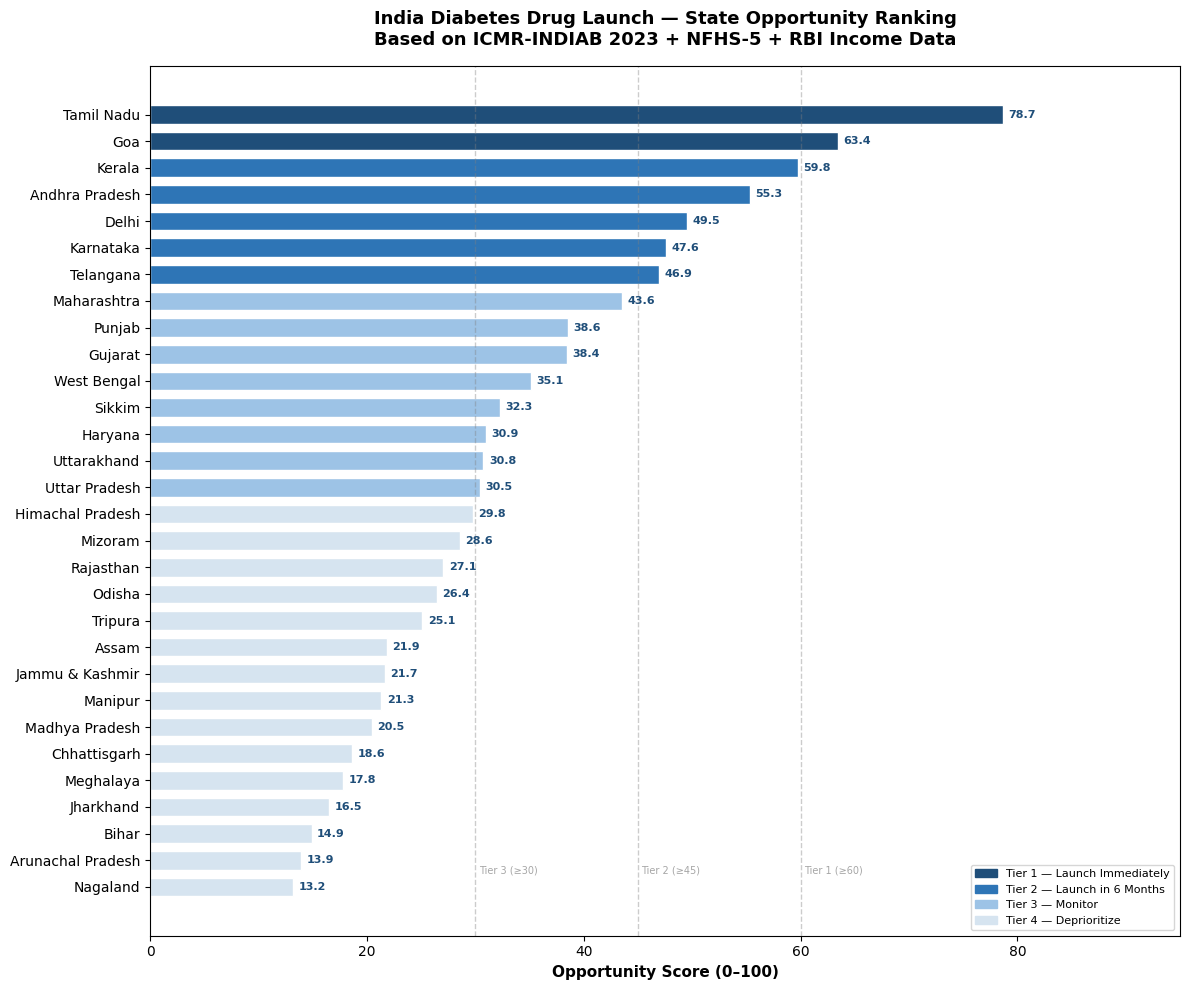

 Chart 1 saved


In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np

# Color mapping by tier
tier_palette = {
    'Tier 1 — Launch Immediately': '#1F4E79',
    'Tier 2 — Launch in 6 Months': '#2E75B6',
    'Tier 3 — Monitor':            '#9DC3E6',
    'Tier 4 — Deprioritize':       '#D6E4F0'
}

master['Color'] = master['Launch_Tier'].map(tier_palette)

# ── CHART 1: State Rankings Bar Chart ──────────────────────────
fig, ax = plt.subplots(figsize=(12, 10))

sorted_master = master.sort_values('Opportunity_Score', ascending=True)

bars = ax.barh(
    sorted_master['State'],
    sorted_master['Opportunity_Score'],
    color=sorted_master['Color'],
    edgecolor='white', height=0.7
)

# Add score labels
for bar, score in zip(bars, sorted_master['Opportunity_Score']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{score:.1f}', va='center', fontsize=8, fontweight='bold',
            color='#1F4E79')

# Tier divider lines
tier_boundaries = {
    'Tier 1 (≥60)': 60,
    'Tier 2 (≥45)': 45,
    'Tier 3 (≥30)': 30
}
for label, val in tier_boundaries.items():
    ax.axvline(x=val, color='gray', linestyle='--', alpha=0.4, linewidth=1)
    ax.text(val+0.3, 0.5, label, fontsize=7, color='gray', alpha=0.7)

# Legend
patches = [mpatches.Patch(color=c, label=t)
           for t, c in tier_palette.items()]
ax.legend(handles=patches, loc='lower right', fontsize=8)

ax.set_xlabel('Opportunity Score (0–100)', fontsize=11, fontweight='bold')
ax.set_title('India Diabetes Drug Launch — State Opportunity Ranking\n'
             'Based on ICMR-INDIAB 2023 + NFHS-5 + RBI Income Data',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlim(0, 95)

plt.tight_layout()
plt.savefig('../data/processed/chart1_state_ranking.png', dpi=150, bbox_inches='tight')
plt.show()
print(" Chart 1 saved")

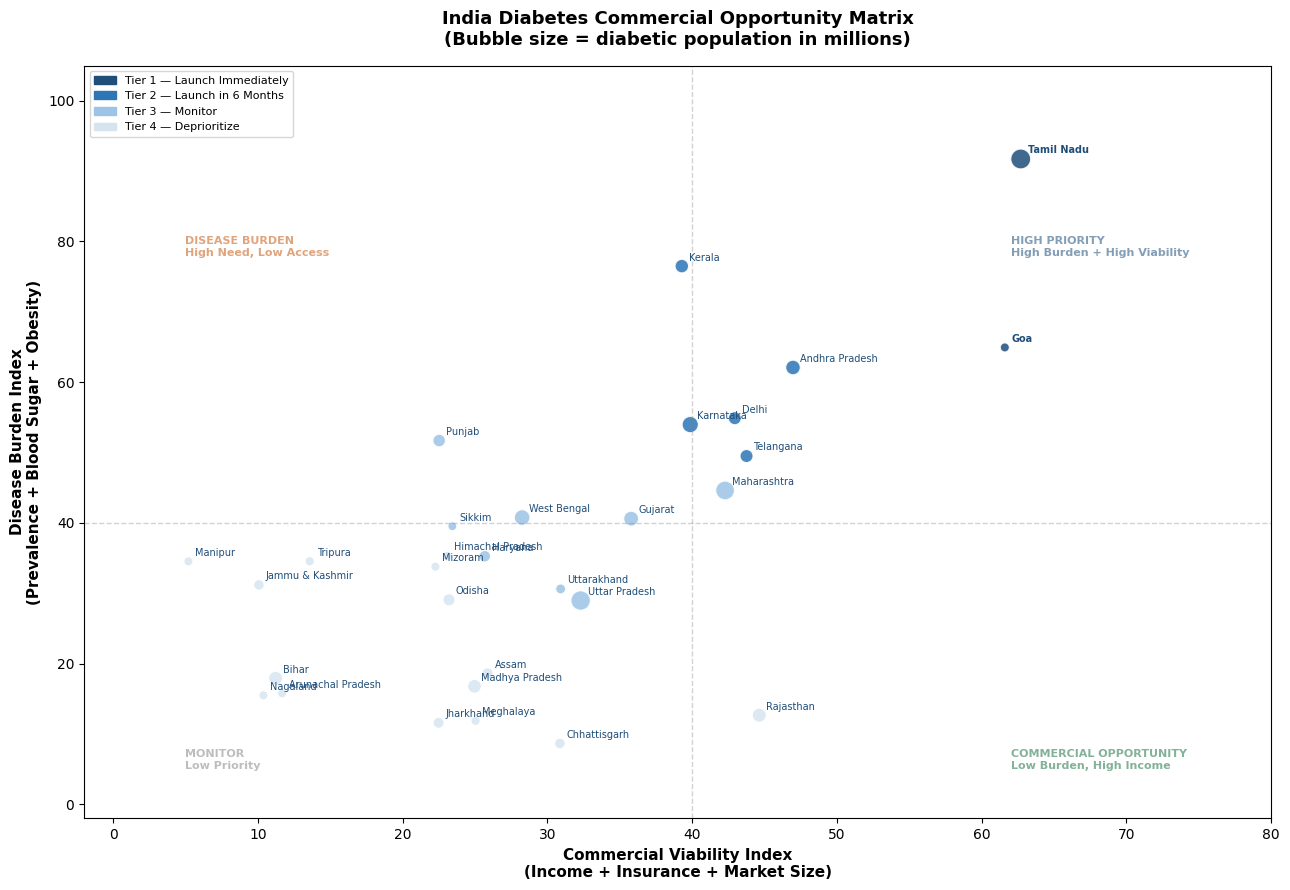

Chart 2 saved


In [60]:
# ── CHART 2: Opportunity Matrix (2x2 Scatter) ──────────────────
fig, ax = plt.subplots(figsize=(13, 9))

for tier, color in tier_palette.items():
    subset = master[master['Launch_Tier'] == tier]
    ax.scatter(
        subset['Commercial_Viability_Index'],
        subset['Disease_Burden_Index'],
        c=color,
        s=subset['Diabetic_Population_Millions'] * 8 + 40,
        label=tier, alpha=0.85,
        edgecolors='white', linewidth=0.8
    )

# Label every state
for _, row in master.iterrows():
    ax.annotate(
        row['State'],
        (row['Commercial_Viability_Index'], row['Disease_Burden_Index']),
        textcoords="offset points", xytext=(5, 4),
        fontsize=7, color='#1F4E79',
        fontweight='bold' if row['Launch_Tier'] == 'Tier 1 — Launch Immediately' else 'normal'
    )

# Quadrant lines
ax.axvline(x=40, color='gray', linestyle='--', alpha=0.35, linewidth=1)
ax.axhline(y=40, color='gray', linestyle='--', alpha=0.35, linewidth=1)

# Quadrant labels
quadrant_labels = [
    (62, 78, 'HIGH PRIORITY\nHigh Burden + High Viability', '#1F4E79'),
    (5,  78, 'DISEASE BURDEN\nHigh Need, Low Access',       '#C55A11'),
    (62, 5,  'COMMERCIAL OPPORTUNITY\nLow Burden, High Income', '#1E7145'),
    (5,  5,  'MONITOR\nLow Priority',                       '#888888'),
]
for x, y, label, color in quadrant_labels:
    ax.text(x, y, label, fontsize=8, color=color,
            fontweight='bold', alpha=0.55)

ax.set_xlabel('Commercial Viability Index\n(Income + Insurance + Market Size)',
              fontsize=11, fontweight='bold')
ax.set_ylabel('Disease Burden Index\n(Prevalence + Blood Sugar + Obesity)',
              fontsize=11, fontweight='bold')
ax.set_title('India Diabetes Commercial Opportunity Matrix\n'
             '(Bubble size = diabetic population in millions)',
             fontsize=13, fontweight='bold', pad=15)

patches = [mpatches.Patch(color=c, label=t) for t, c in tier_palette.items()]
ax.legend(handles=patches, loc='upper left', fontsize=8)
ax.set_xlim(-2, 80)
ax.set_ylim(-2, 105)

plt.tight_layout()
plt.savefig('../data/processed/chart2_opportunity_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 2 saved")

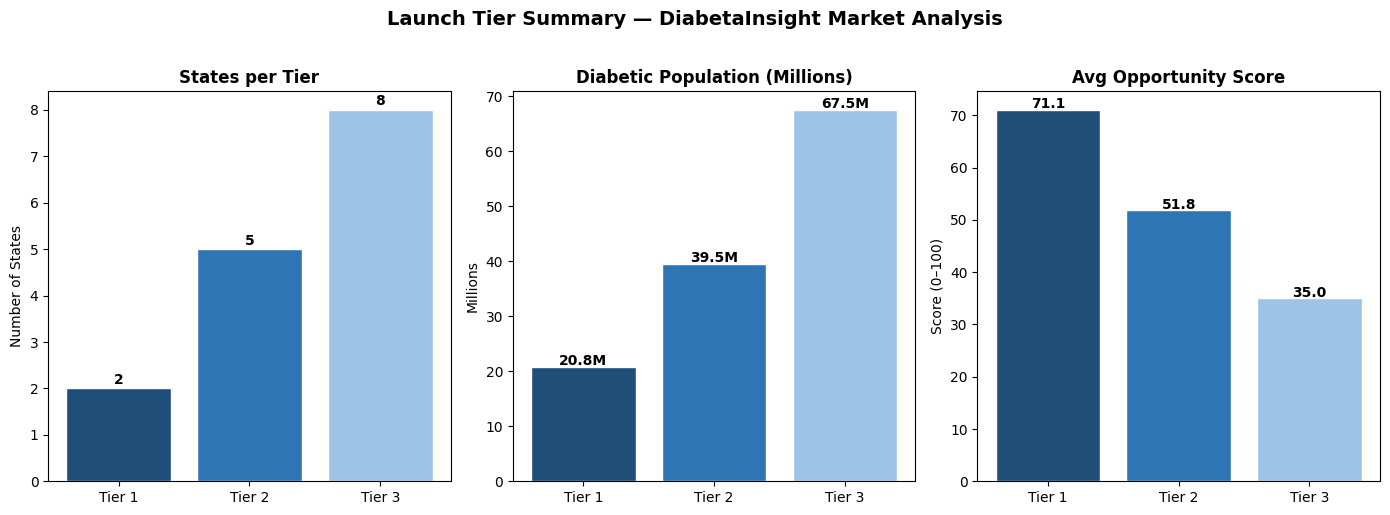

Chart 3 saved


In [58]:
# ── CHART 3: Tier Summary — Business Impact Numbers ────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Launch Tier Summary — DiabetaInsight Market Analysis',
             fontsize=14, fontweight='bold', y=1.02)

tier_order = [
    'Tier 1 — Launch Immediately',
    'Tier 2 — Launch in 6 Months',
    'Tier 3 — Monitor'
]
tier_short = ['Tier 1', 'Tier 2', 'Tier 3']
colors_bar = ['#1F4E79', '#2E75B6', '#9DC3E6']

# Plot 1: Number of states per tier
tier_counts = [len(master[master['Launch_Tier'] == t]) for t in tier_order]
axes[0].bar(tier_short, tier_counts, color=colors_bar, edgecolor='white')
axes[0].set_title('States per Tier', fontweight='bold')
axes[0].set_ylabel('Number of States')
for i, v in enumerate(tier_counts):
    axes[0].text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# Plot 2: Diabetic population per tier
tier_pop = [master[master['Launch_Tier'] == t]['Diabetic_Population_Millions'].sum()
            for t in tier_order]
axes[1].bar(tier_short, tier_pop, color=colors_bar, edgecolor='white')
axes[1].set_title('Diabetic Population (Millions)', fontweight='bold')
axes[1].set_ylabel('Millions')
for i, v in enumerate(tier_pop):
    axes[1].text(i, v + 0.3, f'{v:.1f}M', ha='center', fontweight='bold')

# Plot 3: Average opportunity score per tier
tier_scores = [master[master['Launch_Tier'] == t]['Opportunity_Score'].mean()
               for t in tier_order]
axes[2].bar(tier_short, tier_scores, color=colors_bar, edgecolor='white')
axes[2].set_title('Avg Opportunity Score', fontweight='bold')
axes[2].set_ylabel('Score (0–100)')
for i, v in enumerate(tier_scores):
    axes[2].text(i, v + 0.3, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/chart3_tier_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 3 saved")

FINAL BUSINESS SUMMARY

In [59]:
# ── FINAL BUSINESS SUMMARY ─────────────────────────────────────
print("=" * 60)
print("       DIABETAINSIGHT — MODULE 1 KEY FINDINGS")
print("=" * 60)

t1 = master[master['Launch_Tier'] == 'Tier 1 — Launch Immediately']
t2 = master[master['Launch_Tier'] == 'Tier 2 — Launch in 6 Months']
total_pop = master['Diabetic_Population_Millions'].sum()

print(f"\n📊 INDIA TOTAL DIABETES BURDEN")
print(f"   Total diabetic population: {total_pop:.1f} million")
print(f"   Total at-risk (incl. prediabetes): "
      f"{master['Total_At_Risk_Millions'].sum():.1f} million")

print(f"\n🎯 TIER 1 — LAUNCH IMMEDIATELY")
for _, row in t1.sort_values('Rank').iterrows():
    print(f"   #{row['Rank']} {row['State']:<20} "
          f"Score: {row['Opportunity_Score']:.1f}  |  "
          f"Diabetics: {row['Diabetic_Population_Millions']:.1f}M")
print(f"   Combined diabetic population: "
      f"{t1['Diabetic_Population_Millions'].sum():.1f} million")

print(f"\n📈 TIER 2 — LAUNCH IN 6 MONTHS")
for _, row in t2.sort_values('Rank').iterrows():
    print(f"   #{row['Rank']} {row['State']:<20} "
          f"Score: {row['Opportunity_Score']:.1f}  |  "
          f"Diabetics: {row['Diabetic_Population_Millions']:.1f}M")

print(f"\n⚠️  KEY STRATEGIC INSIGHT")
print(f"   Maharashtra (pop: 123M) ranks #8 — Tier 3")
print(f"   Reason: moderate disease burden + moderate income")
print(f"   Recommendation: enter Maharashtra in Year 2, not Year 1")

print(f"\n💡 MOST SURPRISING FINDING")
print(f"   Goa (#2) outranks Kerala, Delhi, and Maharashtra")
print(f"   Despite only 1.5M population")
print(f"   Reason: highest per capita income (₹516K) in India")
print(f"   = small but highly commercially viable market")

print(f"\n📋 DATA SOURCES")
print(f"   Diabetes prevalence: ICMR-INDIAB 2023, Lancet")
print(f"   Health indicators: NFHS-5 (2019-21), MoHFW GoI")
print(f"   Income data: RBI State Finances Report 2023-24")

# Push to GitHub
print("\n=== RUN IN TERMINAL ===")
print("git add .")
print('git commit -m "Module 1 complete: State opportunity ranking + 3 charts built"')
print("git push origin main")

       DIABETAINSIGHT — MODULE 1 KEY FINDINGS

📊 INDIA TOTAL DIABETES BURDEN
   Total diabetic population: 165.8 million
   Total at-risk (incl. prediabetes): 333.5 million

🎯 TIER 1 — LAUNCH IMMEDIATELY
   #1 Tamil Nadu           Score: 78.7  |  Diabetics: 20.5M
   #2 Goa                  Score: 63.4  |  Diabetics: 0.3M
   Combined diabetic population: 20.8 million

📈 TIER 2 — LAUNCH IN 6 MONTHS
   #3 Kerala               Score: 59.8  |  Diabetics: 6.8M
   #4 Andhra Pradesh       Score: 55.3  |  Diabetics: 8.8M
   #5 Delhi                Score: 49.5  |  Diabetics: 6.0M
   #6 Karnataka            Score: 47.6  |  Diabetics: 12.0M
   #7 Telangana            Score: 46.9  |  Diabetics: 6.0M

⚠️  KEY STRATEGIC INSIGHT
   Maharashtra (pop: 123M) ranks #8 — Tier 3
   Reason: moderate disease burden + moderate income
   Recommendation: enter Maharashtra in Year 2, not Year 1

💡 MOST SURPRISING FINDING
   Goa (#2) outranks Kerala, Delhi, and Maharashtra
   Despite only 1.5M population
   Reason